In [1]:
import tensorflow as tf 

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score

from tqdm import tqdm
import os 

tqdm.pandas()

# my Helper functions

from HelperFunctions import *

## Plotando dados: TA x Spectral indices , TA X Spectral bands
### TA x (NDMI, MNDWI, PET) - I'll have to concatenate PET data

In [2]:
landsat_training_data = pd.read_csv('../Datasets/landsat_features_training.csv')
terra_climate_training_data = pd.read_csv('../Datasets/terraclimate_features_training.csv')
explained_variables = pd.read_csv('../Datasets/water_quality_training_dataset.csv')

joined_explaining_vars = combine_two_datasets(landsat_training_data, terra_climate_training_data)
full_dataset = combine_two_datasets(joined_explaining_vars, explained_variables)


full_dataset = scale_data_return_dataframe(full_dataset, ['Latitude', 'Longitude', 'Sample Date'])

ranges_information = [f'{column} , range: {full_dataset[column].min()} to {full_dataset[column].max()}' for column in full_dataset.columns.drop(['Latitude', 'Longitude', 'Sample Date']).values]
for information in ranges_information:
    print(information)

full_dataset.head()

nir , range: -3.6271221711013397 to 18.54121454903997
green , range: -2.2648745632712957 to 21.271913894797272
swir16 , range: -3.148641966474785 to 16.504784551930914
swir22 , range: -3.244553310935656 to 8.26308758316535
NDMI , range: -4.775986555224925 to 7.4641836371592865
MNDWI , range: -1.6664506016902654 to 8.013638642284759
pet , range: -4.155860468861563 to 3.2453173594548543
Total Alkalinity , range: -1.5304642560980177 to 3.247722477262238
Electrical Conductance , range: -1.374254167921542 to 2.9860718223437113
Dissolved Reactive Phosphorus , range: -0.7557328056145404 to 2.971404721266379


,Latitude,Longitude,Sample Date,nir,green,swir16,swir22,NDMI,MNDWI,pet,Total Alkalinity,Electrical Conductance,Dissolved Reactive Phosphorus
0,-28.760833,17.730278,02-01-2011,-1.034338,0.560382,-1.873095,-1.570282,2.241863,3.720340,-0.032784,0.131262,0.204714,-0.657650
1,-26.861111,28.884722,03-01-2011,1.295673,-0.157702,0.051821,-0.347659,1.409113,-0.359582,-1.732917,-0.594310,-0.942047,2.343676
2,-26.450000,28.085833,03-01-2011,0.413701,0.290144,1.394878,1.166323,-1.429805,-1.148694,-1.617538,-0.399716,0.257358,0.715506
3,-27.671111,27.236944,03-01-2011,0.297354,0.375502,-0.019502,-0.001618,0.364039,0.451762,-1.542882,-0.496839,-0.823013,1.127452
4,-27.356667,27.286389,03-01-2011,0.996699,-0.175884,-0.291608,-0.736277,1.635577,0.047089,-1.559849,-0.843612,-0.994106,2.108278


## TA x NDMI

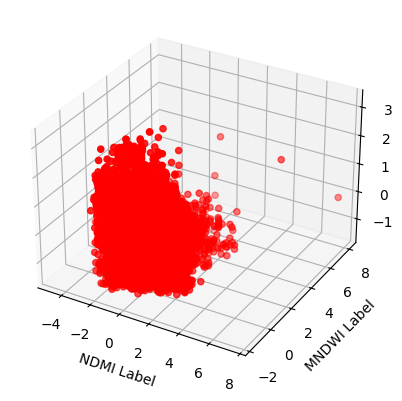

In [3]:
#making a 3d plot of NDMI and MNDWI (x, y) data in full_dataset against "Total Alkalinity" (z)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(full_dataset['NDMI'], full_dataset['MNDWI'], full_dataset['Total Alkalinity'], c='r', marker='o')
ax.set_xlabel('NDMI Label')
ax.set_ylabel('MNDWI Label')
ax.set_zlabel('Total Alkalinity Label')
plt.show()

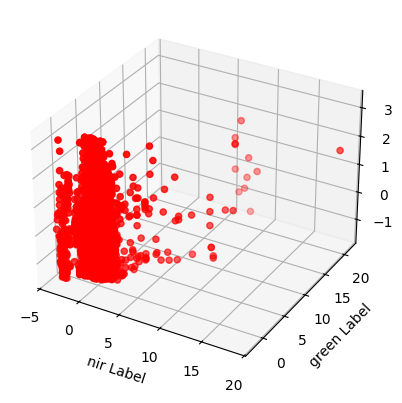

In [4]:
#making a 3d plot of nir and green (x, y) data in full_dataset against "Total Alkalinity" (z)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(full_dataset['nir'], full_dataset['green'], full_dataset['Total Alkalinity'], c='r', marker='o')
ax.set_xlabel('nir Label')
ax.set_ylabel('green Label')
ax.set_zlabel('Total Alkalinity Label')
plt.show()

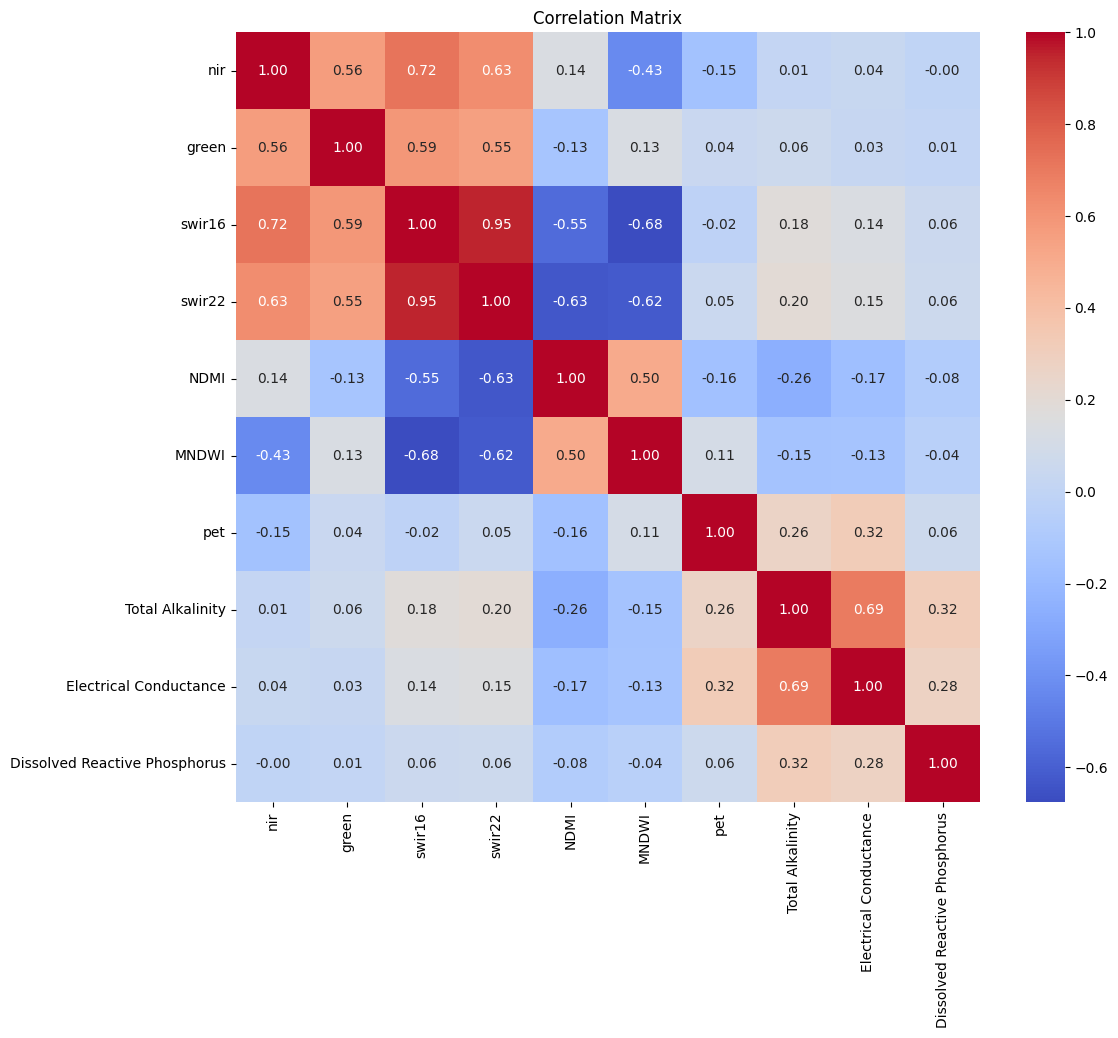

In [5]:
# plotting a correlation Matrix of all the data in full_dataset ( excluding "Latitude", "Longitude", "Sample Date")
correlation_matrix = full_dataset.drop(columns=['Latitude', 'Longitude', 'Sample Date']).corr()
plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


### This Plot hihglights ONLY Linear Relationships, we'll plot those relationships and then we will see if there is any qadratic / cubic relationships between variables
### Ploting Strong Correlation variables, in linear analysis

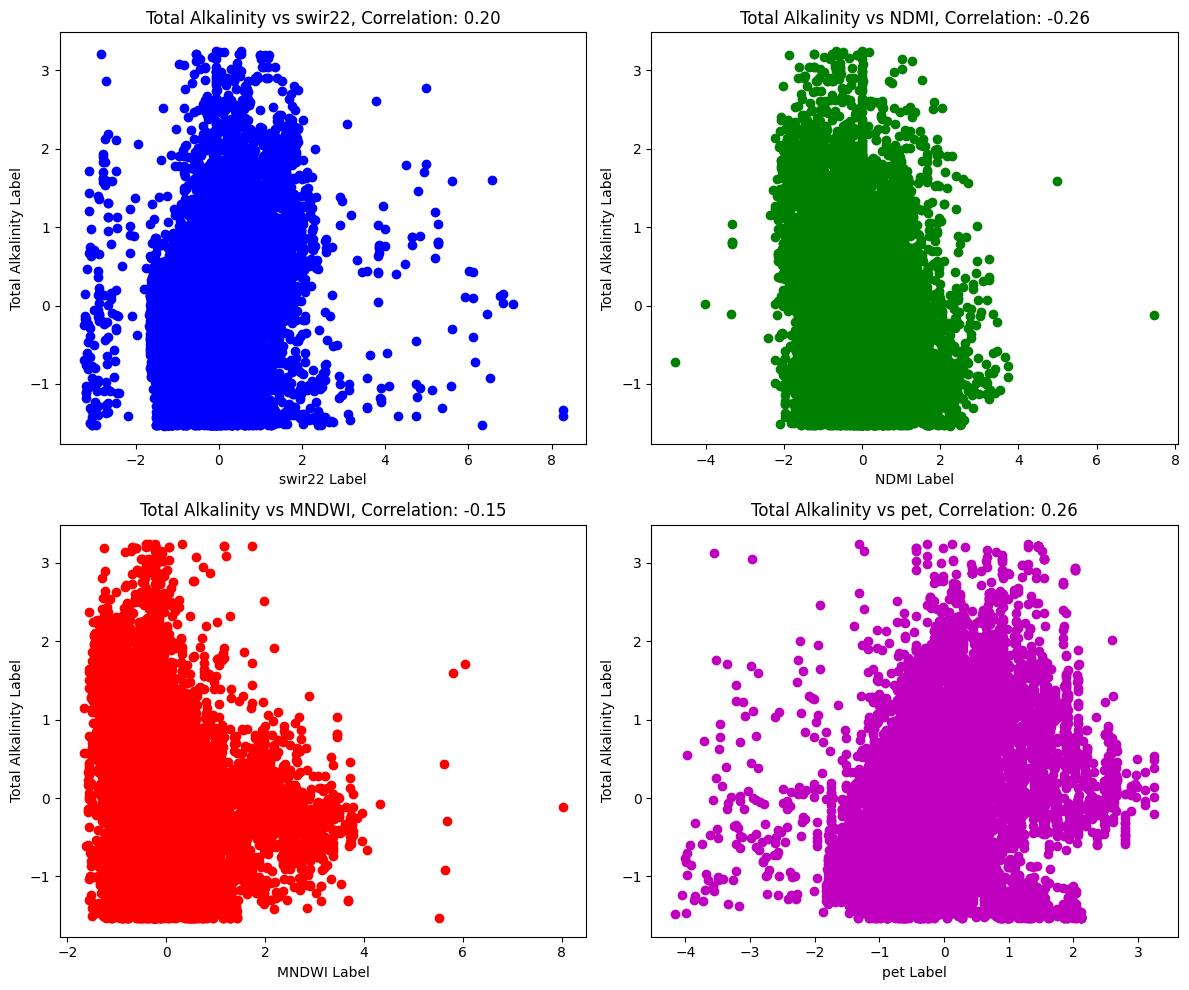

In [6]:
# making 4 plots: "Total Alkalinity" against "swir22", "NDMI", "MNDWI", "pet"
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs[0, 0].scatter(full_dataset['swir22'], full_dataset['Total Alkalinity'], c='b', marker='o')
axs[0, 0].set_xlabel('swir22 Label')
axs[0, 0].set_ylabel('Total Alkalinity Label')
axs[0, 0].set_title(f'Total Alkalinity vs swir22, Correlation: {correlation_matrix.loc["swir22", "Total Alkalinity"]:.2f}')
axs[0, 1].scatter(full_dataset['NDMI'], full_dataset['Total Alkalinity'], c='g', marker='o')
axs[0, 1].set_xlabel('NDMI Label')
axs[0, 1].set_ylabel('Total Alkalinity Label')
axs[0, 1].set_title(f'Total Alkalinity vs NDMI, Correlation: {correlation_matrix.loc["NDMI", "Total Alkalinity"]:.2f}')
axs[1, 0].scatter(full_dataset['MNDWI'], full_dataset['Total Alkalinity'], c='r', marker='o')
axs[1, 0].set_xlabel('MNDWI Label')
axs[1, 0].set_ylabel('Total Alkalinity Label')
axs[1, 0].set_title(f'Total Alkalinity vs MNDWI, Correlation: {correlation_matrix.loc["MNDWI", "Total Alkalinity"]:.2f}')
axs[1, 1].scatter(full_dataset['pet'], full_dataset['Total Alkalinity'], c='m', marker='o')
axs[1, 1].set_xlabel('pet Label')
axs[1, 1].set_ylabel('Total Alkalinity Label')
axs[1, 1].set_title(f'Total Alkalinity vs pet, Correlation: {correlation_matrix.loc["pet", "Total Alkalinity"]:.2f}')
plt.tight_layout()
plt.show()

### Adding quadratic data

In [7]:
quadradic_full_dataset = full_dataset.copy()
quadradic_full_dataset['swir22_squared'] = quadradic_full_dataset['swir22'] ** 2
quadradic_full_dataset['NDMI_squared'] = quadradic_full_dataset['NDMI'] ** 2
quadradic_full_dataset['MNDWI_squared'] = quadradic_full_dataset['MNDWI'] ** 2
quadradic_full_dataset['pet_squared'] = quadradic_full_dataset['pet'] ** 2
quadradic_full_dataset['nir_squared'] = quadradic_full_dataset['nir'] ** 2
quadradic_full_dataset['green_squared'] = quadradic_full_dataset['green'] ** 2
quadradic_full_dataset['swir16_squared'] = quadradic_full_dataset['swir16'] ** 2

quadradic_full_dataset.drop(columns=['MNDWI', 'NDMI', 'swir22', 'pet', 'nir', 'green', 'swir16'], inplace=True)
quadradic_full_dataset.head()

,Latitude,Longitude,Sample Date,Total Alkalinity,Electrical Conductance,Dissolved Reactive Phosphorus,swir22_squared,NDMI_squared,MNDWI_squared,pet_squared,nir_squared,green_squared,swir16_squared
0,-28.760833,17.730278,02-01-2011,0.131262,0.204714,-0.657650,2.465786,5.025952,13.840926,0.001075,1.069856,0.314028,3.508486
1,-26.861111,28.884722,03-01-2011,-0.594310,-0.942047,2.343676,0.120867,1.985598,0.129299,3.003000,1.678768,0.024870,0.002685
2,-26.450000,28.085833,03-01-2011,-0.399716,0.257358,0.715506,1.360309,2.044342,1.319499,2.616430,0.171149,0.084183,1.945684
3,-27.671111,27.236944,03-01-2011,-0.496839,-0.823013,1.127452,0.000003,0.132524,0.204089,2.380484,0.088419,0.141002,0.000380
4,-27.356667,27.286389,03-01-2011,-0.843612,-0.994106,2.108278,0.542104,2.675111,0.002217,2.433130,0.993410,0.030935,0.085035


### Checking for quadratic relationships

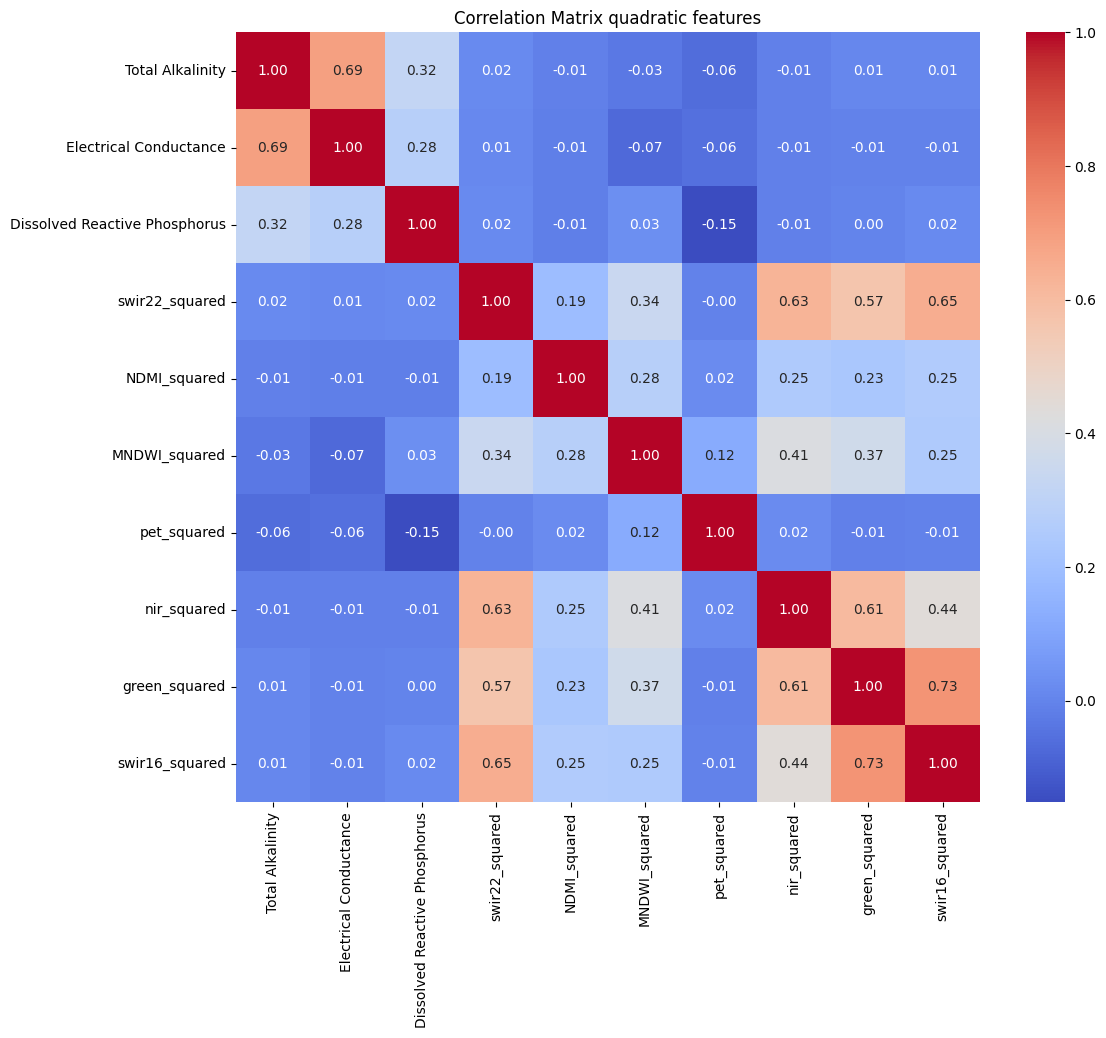

In [8]:
correlation_matrix = quadradic_full_dataset.drop(columns=['Latitude', 'Longitude', 'Sample Date']).corr()
plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix quadratic features')
plt.show()

### Seing Cubic Relationship

In [9]:
cubic_full_dataset = full_dataset.copy()
cubic_full_dataset['swir22_cubed'] = cubic_full_dataset['swir22'] ** 3
cubic_full_dataset['NDMI_cubed'] = cubic_full_dataset['NDMI'] ** 3
cubic_full_dataset['MNDWI_cubed'] = cubic_full_dataset['MNDWI'] ** 3
cubic_full_dataset['pet_cubed'] = cubic_full_dataset['pet'] ** 3
cubic_full_dataset['nir_cubed'] = cubic_full_dataset['nir'] ** 3
cubic_full_dataset['green_cubed'] = cubic_full_dataset['green'] ** 3
cubic_full_dataset['swir16_cubed'] = cubic_full_dataset['swir16'] ** 3

cubic_full_dataset.drop(columns=['MNDWI', 'NDMI', 'swir22', 'pet', 'nir', 'green', 'swir16'], inplace=True)
cubic_full_dataset.head()

,Latitude,Longitude,Sample Date,Total Alkalinity,Electrical Conductance,Dissolved Reactive Phosphorus,swir22_cubed,NDMI_cubed,MNDWI_cubed,pet_cubed,nir_cubed,green_cubed,swir16_cubed
0,-28.760833,17.730278,02-01-2011,0.131262,0.204714,-0.657650,-3.871979e+00,11.267497,51.492945,-0.000035,-1.106593,0.175976,-6.571728
1,-26.861111,28.884722,03-01-2011,-0.594310,-0.942047,2.343676,-4.202046e-02,2.797932,-0.046494,-5.203949,2.175134,-0.003922,0.000139
2,-26.450000,28.085833,03-01-2011,-0.399716,0.257358,0.715506,1.586560e+00,-2.923009,-1.515701,-4.232176,0.070804,0.024425,2.713990
3,-27.671111,27.236944,03-01-2011,-0.496839,-0.823013,1.127452,-4.235805e-09,0.048244,0.092199,-3.672806,0.026292,0.052947,-0.000007
4,-27.356667,27.286389,03-01-2011,-0.843612,-0.994106,2.108278,-3.991387e-01,4.375349,0.000104,-3.795315,0.990131,-0.005441,-0.024797


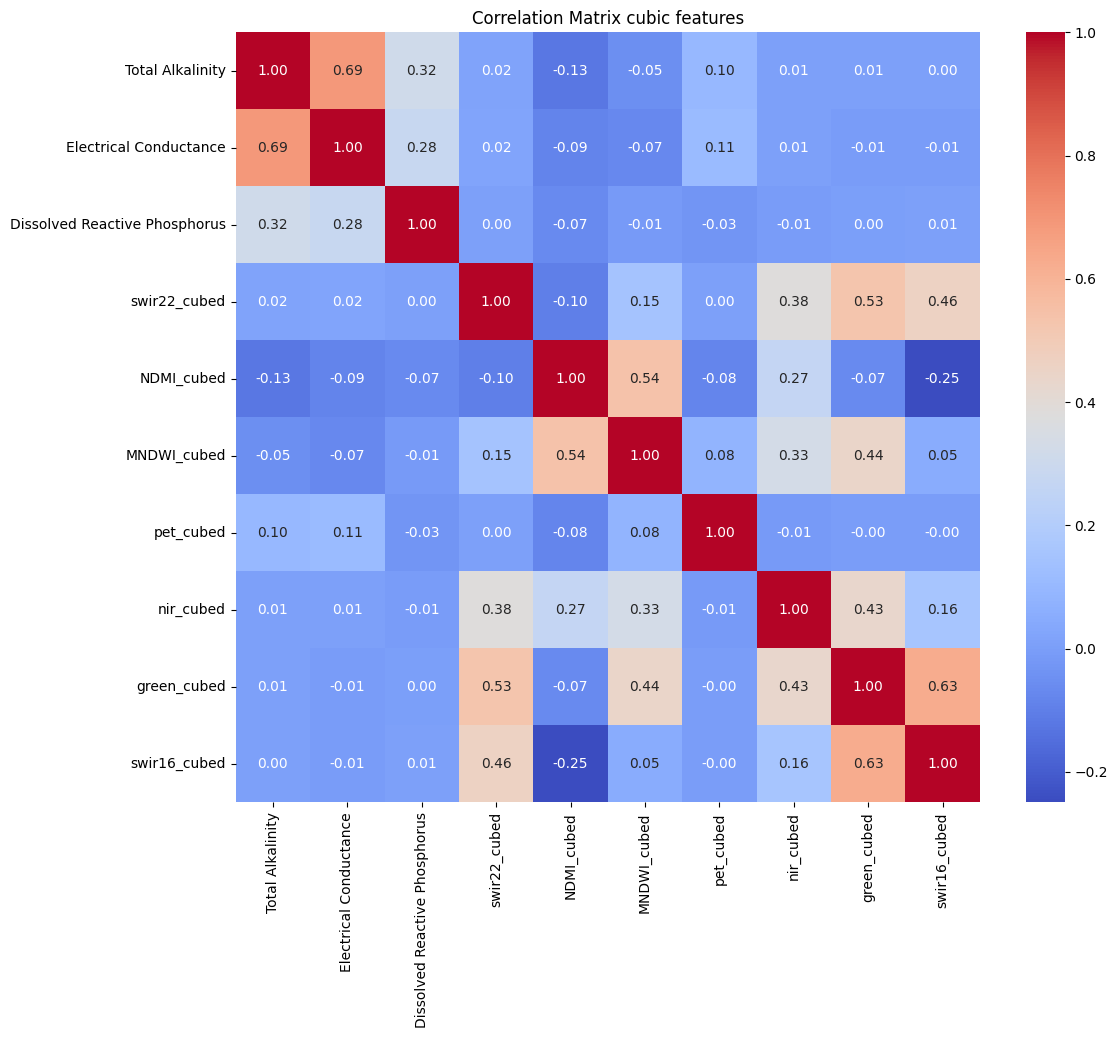

In [10]:
correlation_matrix = cubic_full_dataset.drop(columns=['Latitude', 'Longitude', 'Sample Date']).corr()
plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix cubic features')
plt.show()

### Creating Simple Linear Model

In [54]:
all_data = combine_two_datasets(full_dataset, quadradic_full_dataset)
all_data = combine_two_datasets(all_data, cubic_full_dataset)
all_data.head()

feature_input_columns = all_data.columns.drop(['Latitude', 'Longitude', 'Sample Date', 'Total Alkalinity', 'Electrical Conductance', 'Dissolved Reactive Phosphorus'])
target_columns = ['Total Alkalinity']



In [84]:
max_iterations = 4000

model_ridge = Ridge(alpha = 0.001, max_iter= max_iterations)
model_lasso = Lasso(alpha = 0.001, max_iter= max_iterations)
model_lasso



,"alpha alpha: float, default=1.0Constant that multiplies the L1 term, controlling regularizationstrength. `alpha` must be a non-negative float i.e. in `[0, inf)`.When `alpha = 0`, the objective is equivalent to ordinary leastsquares, solved by the :class:`LinearRegression` object. For numericalreasons, using `alpha = 0` with the `Lasso` object is not advised.Instead, you should use the :class:`LinearRegression` object.",0.001
,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"precompute precompute: bool or array-like of shape (n_features, n_features), default=FalseWhether to use a precomputed Gram matrix to speed upcalculations. The Gram matrix can also be passed as argument.For sparse input this option is always ``False`` to preserve sparsity.",False
,"copy_X copy_X: bool, default=TrueIf ``True``, X will be copied; else, it may be overwritten.",True
,"max_iter max_iter: int, default=1000The maximum number of iterations.",4000
,"tol tol: float, default=1e-4The tolerance for the optimization: if the updates are smaller or equal to``tol``, the optimization code checks the dual gap for optimality and continuesuntil it is smaller or equal to ``tol``, see Notes below.",0.0001
,"warm_start warm_start: bool, default=FalseWhen set to ``True``, reuse the solution of the previous call to fit asinitialization, otherwise, just erase the previous solution.See :term:`the Glossary `.",False
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive.",False
,"random_state random_state: int, RandomState instance, default=NoneThe seed of the pseudo random number generator that selects a randomfeature to update. Used when ``selection`` == 'random'.Pass an int for reproducible output across multiple function calls.See :term:`Glossary `.",None
,"selection selection: {'cyclic', 'random'}, default='cyclic'If set to 'random', a random coefficient is updated every iterationrather than looping over features sequentially by default. This(setting to 'random') often leads to significantly faster convergenceespecially when tol is higher than 1e-4.",'cyclic'


In [85]:

train, test = train_test_split(all_data, test_size=0.25)

X_train = train[feature_input_columns]
y_train = train[target_columns]

X_test = test[feature_input_columns]
y_test = test[target_columns]

X_test.head()



,nir,green,swir16,swir22,NDMI,MNDWI,pet,swir22_squared,NDMI_squared,MNDWI_squared,...,nir_squared,green_squared,swir16_squared,swir22_cubed,NDMI_cubed,MNDWI_cubed,pet_cubed,nir_cubed,green_cubed,swir16_cubed
1778,-0.390825,-0.375884,-0.980213,-1.049551,1.149838,0.750178,0.014725,1.101557,1.322128,0.562767,...,0.152744,0.141289,0.960817,-1.156140,1.520234,0.422175,0.000003,-0.059696,-0.053108,-0.941805
6970,0.887196,0.274067,1.690175,2.037896,-1.209327,-1.422950,-0.100653,4.153019,1.462473,2.024787,...,0.787117,0.075113,2.856693,8.463419,-1.768608,-2.881172,-0.001020,0.698327,0.020586,4.828312
6231,-1.160772,-0.492438,-0.693175,-0.241008,-0.637628,0.122077,-0.738627,0.058085,0.406569,0.014903,...,1.347391,0.242496,0.480491,-0.013999,-0.259240,0.001819,-0.402973,-1.564014,-0.119414,-0.333065
147,0.416763,0.142393,0.365862,0.334614,-0.071736,-0.309861,1.470527,0.111966,0.005146,0.096014,...,0.173691,0.020276,0.133855,0.037465,-0.000369,-0.029751,3.179943,0.072388,0.002887,0.048973
355,-0.036920,-0.013779,0.499771,0.478206,-0.853936,-0.667941,-0.361951,0.228681,0.729206,0.446146,...,0.001363,0.000190,0.249771,0.109357,-0.622696,-0.297999,-0.047419,-0.000050,-0.000003,0.124828


In [86]:
model_ridge.fit(X_train, y_train)
model_lasso.fit(X_train, y_train)

#getting training error of each model
y_train_pred_ridge = model_ridge.predict(X_train)
y_train_pred_lasso = model_lasso.predict(X_train)

y_test_pred_ridge = model_ridge.predict(X_test)
y_test_pred_lasso = model_lasso.predict(X_test)



In [87]:
evaluate_model(y_test_pred_ridge, y_test, dataset_name=' all data_test Ridge Regression')
evaluate_model(y_test_pred_lasso, y_test, dataset_name=' all data_test Lasso Regression')
print("\n \n")

evaluate_model(y_train_pred_ridge, y_train, dataset_name=' all data_train Ridge Regression')
evaluate_model(y_train_pred_lasso, y_train, dataset_name=' all data_train Lasso Regression')


 all data_test Ridge Regression Evaluation:
R²: 0.164
RMSE: 0.922

 all data_test Lasso Regression Evaluation:
R²: 0.163
RMSE: 0.922

 


 all data_train Ridge Regression Evaluation:
R²: 0.165
RMSE: 0.911

 all data_train Lasso Regression Evaluation:
R²: 0.164
RMSE: 0.912


(array([ 0.26416935,  0.28039421, -0.48539639, ..., -0.09448207,
        -0.1079454 ,  0.39718842]),
 0.16412701638632976,
 np.float64(0.9116006256980635))